# SFNINCS Builder integration
### Author: Tadd Bindas

The purpose of this notebook is to walk through the steps of integrating the coastal tools functionality into your code and getting initial parameter estimates. 

In [1]:
import os
from io import StringIO
from pathlib import Path

import geopandas as gpd
import hydromt
import numpy as np
import pandas as pd
import xarray as xr

Let's set up the Data Catalogs and paths to data

In [2]:
data_catalog_path = Path.cwd().parent / "data/data_catalogs"
ngei_lib = str(data_catalog_path / "nos/coastal_lidar.yaml")
lynker_lib = str(data_catalog_path / "lynker_spatial/gridded_data.yaml")

See below for what a data catalog object looks like

In [3]:
data_catalog = hydromt.DataCatalog(data_libs=[lynker_lib])
ds = data_catalog.get_rasterdataset("dem")
ds

<xarray.DataArray 'elevtn' (y: 114503, x: 163008)> Size: 75GB
dask.array<getitem, shape=(114503, 163008), dtype=int32, chunksize=(3600, 3600), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 1MB -2.471e+06 -2.471e+06 ... 2.419e+06 2.419e+06
  * y            (y) float64 916kB 3.621e+06 3.621e+06 ... 1.863e+05 1.863e+05
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:   -2147483647
    source_file:  dem.vrt

Let's set up all of our input variables below for our test case

In [4]:
stofs_data = """ref_id,Lon,Lat
1,-96.22029,28.57183
2,-96.15505,28.58662
3,-96.07669,28.61743
4,-96.01858,28.61247
5,-95.99234,28.57649
6,-95.94361,28.59862
7,-95.92857,28.64843
8,-95.91665,28.69935"""

lower_colorado_stofs_points = pd.read_csv(StringIO(stofs_data))

lower_colorado_start_time = np.datetime64('2023-04-01T01:00:00.000000000')

lower_colorado_end_time = np.datetime64('2023-04-03T00:00:00.000000000')

forcing_path = Path.cwd().parent / "tests/data/20230401_stofs_elev2D.th.nc"
lower_colordao_boundary_forcings = xr.open_dataset(forcing_path)

forcing_path = Path.cwd().parent / "tests/data/sflux_air_1.0001.nc"
ds = xr.open_dataset(forcing_path)
ds = ds.rio.write_crs("EPSG:4326", inplace=True)
ds.raster.set_spatial_dims(x_dim="nx_grid", y_dim="ny_grid")
lower_colorado_meterological_forcings = ds.rename({"rain": "precip"})

lower_colorado_depth_definition = [
    {"elevtn": "dem", "zmin": 0.1, "zmax":25},
    {"elevtn": "USGS_seamless_13"},
]

lower_colorado_data_catalogs = [
    ngei_lib,
    lynker_lib
]

lower_colorado_predefined_grid = {
    "x0":-10687089,
    "y0":3321498,
    "dy":50,
    "dx":50,
    "nmax":150,
    "mmax":250,
    "rotation":24,
    "epsg":3857,
}

lower_colorado_terminal_node = "tnx-1000006230"
lower_colorado_terminal_watershed_boundary = "wb-2430687"

cross_section_path = Path.cwd().parent / "tests/data/lower_colorado_cross_sections.parquet"
lower_colorado_cross_sections = pd.read_parquet(cross_section_path)

lower_colorado_path =  Path.cwd().parent / "tests/data/lower_colorado_v22.gpkg"
lower_colorado_nexus_points = gpd.read_file(lower_colorado_path, layer="nexus")
lower_colorado_divides = gpd.read_file(lower_colorado_path, layer="nexus")
lower_colorado_flowpaths = gpd.read_file(lower_colorado_path, layer="flowpaths")
lower_colorado_flowpath_attributes = gpd.read_file(lower_colorado_path, layer="flowpath-attributes-ml")

Now, let's run and visualize some of these sfincs models

In [5]:
import coastal_tools as coast

tmp_path = Path.cwd() / "tmp"
tmp_path.mkdir(exist_ok=True)

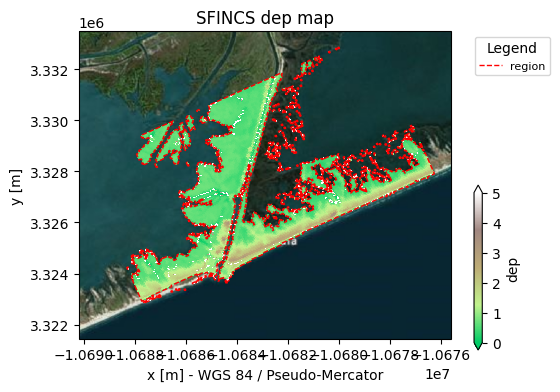

In [6]:
sf = coast.initialize_sfincs_model(
    str(tmp_path),
    lower_colorado_data_catalogs,
    lower_colorado_predefined_grid,
    lower_colorado_depth_definition,
)
_ = sf.plot_basemap(plot_region=True, bmap="sat", zoomlevel=12)

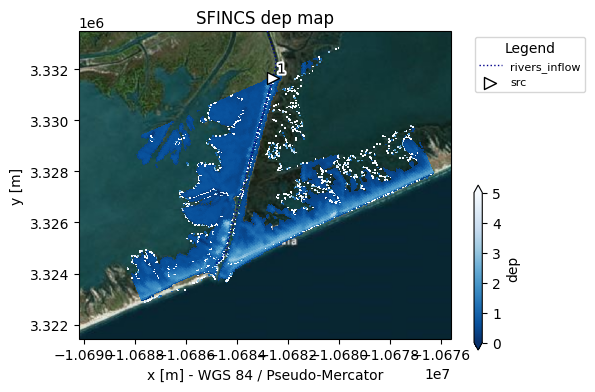

In [7]:
sf = coast.add_hydrofabric_outflow(
    sf,
    lower_colorado_divides,
    lower_colorado_nexus_points,
    lower_colorado_terminal_node
)
sf.setup_river_inflow(
    rivers=lower_colorado_flowpaths, keep_rivers_geom=True
)
fig, ax = sf.plot_basemap(
    variable="dep",
    plot_bounds=False,
    bmap="sat",
    zoomlevel=12,
    cmap='Blues_r',
)

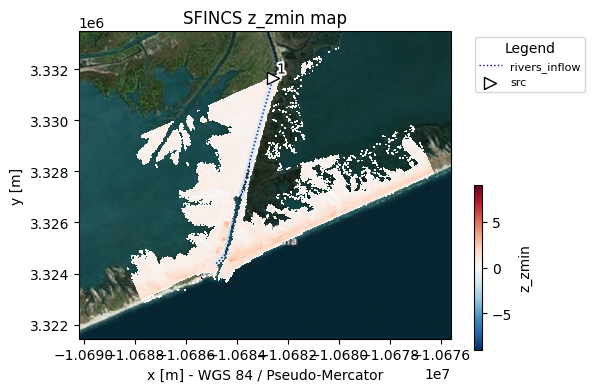

In [8]:
sf = coast.setup_subgrid(
    sf,
    lower_colorado_depth_definition,
    lower_colorado_flowpath_attributes,
)
_ = sf.plot_basemap(
    variable="subgrid.z_zmin", plot_bounds=False, bmap="sat", zoomlevel=12
)

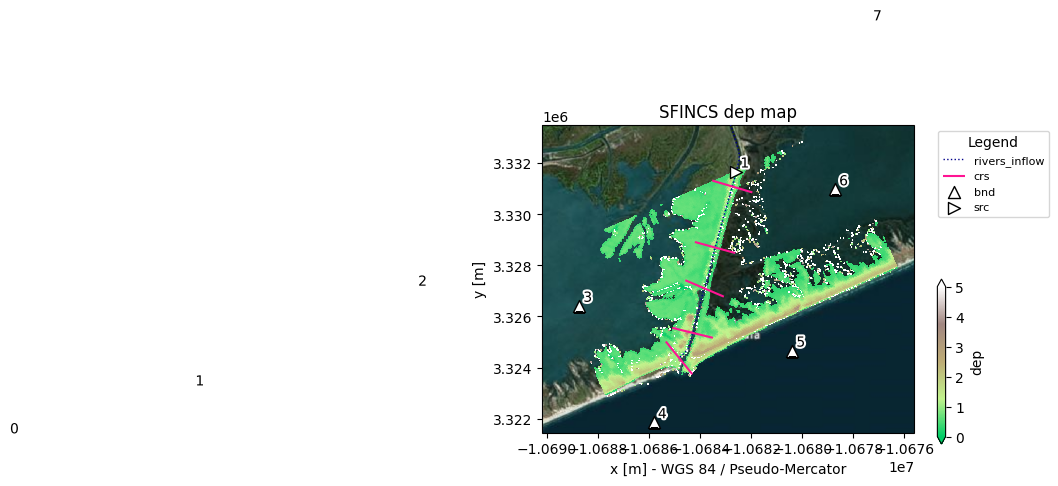

In [9]:
sf = coast.setup_water_level_boundaries(
    sf,
    lower_colorado_start_time,
    lower_colorado_end_time,
    lower_colorado_stofs_points,
    lower_colordao_boundary_forcings,
)
sf = coast.setup_meterological_forcings(
    sf,
    lower_colorado_meterological_forcings
)
sf = coast.setup_observational_cross_sections(
    sf,
    lower_colorado_cross_sections,
)
_ = sf.plot_basemap(fn_out="basemap.png", bmap="sat", zoomlevel=12)


In [10]:
sf.write()
dir_list = os.listdir(sf.root)
print(dir_list)

['sfincs.dis', 'sfincs.msk', 'hydromt.log', 'figs', 'sfincs.src', 'sfincs.bzs', 'sfincs.bnd', 'sfincs.crs', 'sfincs_subgrid.nc', 'subgrid', 'hydromt_data.yml', 'sfincs.ind', 'sfincs.inp', 'gis']


Our SFINCS model is all set up and ready to go! 

*NOTE:* the reason there are numbres above off the chart is those boundary forcings are outside of the sat view. It's a plotting problem that will not effect the model.